`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

2024-04-07 12:40:00.857647: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-07 12:40:01.818067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/opt/hostedtoolcache/Python/3.11.8/x64/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.169905


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Fairness metrics on transformed training dataset

Disparate Impact (favorable label): 1.0000000000000004
Statistical Parity Difference (favorable label): 3.3306690738754696e-16
Equal Opportunity Difference: 0.0
Equalized Odds Difference: 0.0
Average Odds Difference: 0.0
Theil Index: 0.0


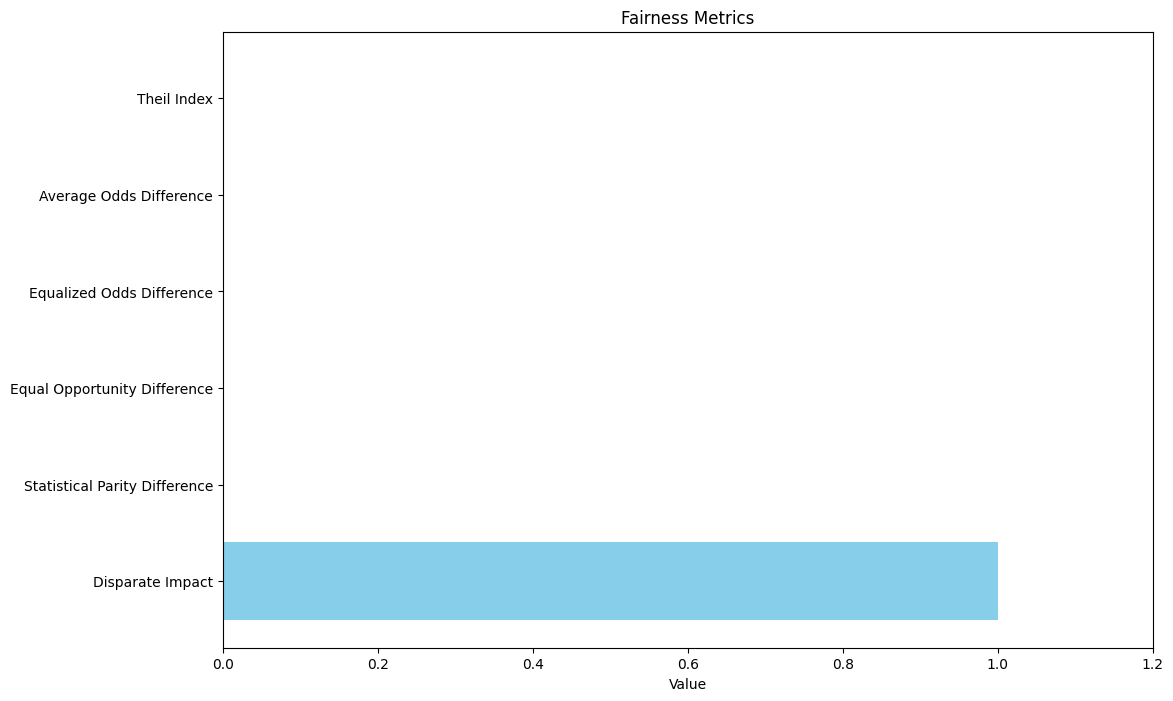

In [1]:
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

import time

# Add a sleep statement to wait for imports to be fully loaded
time.sleep(20)  # You can adjust the sleep duration based on your needs

from aif360.datasets import GermanDataset
time.sleep(20)
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
time.sleep(20)
from aif360.algorithms.preprocessing import Reweighing
time.sleep(20)

from IPython.display import Markdown, display
time.sleep(20)

# Import matplotlib for visualization
import matplotlib.pyplot as plt

dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

# Additional fairness metrics
display(Markdown("#### Fairness metrics on transformed training dataset"))

# Disparate Impact
disparate_impact = metric_transf_train.disparate_impact()
print("Disparate Impact (favorable label):", disparate_impact)

# Statistical Parity Difference
statistical_parity_difference = metric_transf_train.statistical_parity_difference()
print("Statistical Parity Difference (favorable label):", statistical_parity_difference)

# Create a new dataset by applying the same preprocessing steps as the transformed dataset
dataset_orig_train_pred = RW.transform(dataset_orig_train)

# Classification Metrics
classified_metric_transf_train = ClassificationMetric(dataset_orig_train_pred, 
                                                      dataset_transf_train,
                                                      unprivileged_groups=unprivileged_groups,
                                                      privileged_groups=privileged_groups)

# Equal Opportunity Difference
equal_opportunity_difference = classified_metric_transf_train.equal_opportunity_difference()
print("Equal Opportunity Difference:", equal_opportunity_difference)

# Equalized Odds Difference
equalized_odds_difference = classified_metric_transf_train.equalized_odds_difference()
print("Equalized Odds Difference:", equalized_odds_difference)

# Average Odds Difference
average_odds_difference = classified_metric_transf_train.average_odds_difference()
print("Average Odds Difference:", average_odds_difference)

# Theil Index
theil_index = classified_metric_transf_train.theil_index()
print("Theil Index:", theil_index)

# Define function to plot fairness metrics
def plot_fairness_metrics(disparate_impact, statistical_parity_difference, equal_opportunity_difference, 
                          equalized_odds_difference, average_odds_difference, theil_index):
    labels = ['Disparate Impact', 'Statistical Parity Difference', 'Equal Opportunity Difference', 
              'Equalized Odds Difference', 'Average Odds Difference', 'Theil Index']
    metrics = [disparate_impact, statistical_parity_difference, equal_opportunity_difference, 
               equalized_odds_difference, average_odds_difference, theil_index]

    plt.figure(figsize=(12, 8))
    plt.barh(labels, metrics, color='skyblue')
    plt.title('Fairness Metrics')
    plt.xlabel('Value')
    plt.xlim(0, max(metrics) * 1.2)  # Adjust xlim for better visualization
    plt.show()

# Plot fairness metrics
plot_fairness_metrics(disparate_impact, statistical_parity_difference, equal_opportunity_difference, 
                      equalized_odds_difference, average_odds_difference, theil_index)
